In [27]:
#### Import packages ####
import copy
import itertools
import math
import os
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import networkx as nx
from matplotlib import cm
import pandas as pd

import trajectory as traj

In [28]:
def check_intersection(px, py, x1, y1, x2, y2, node_size, edge_width, dim):
    """ Check if a point intersects a line segment based on node size and edge width. """
    atol = node_size / 25  # Tolerance based on half the node size
    rtol = edge_width / 50  # Tolerance based on half the edge width
    #py = py+(0.015*dim)
    if min(x1, x2) <= px <= max(x1, x2) and min(y1, y2) <= py <= max(y1, y2):
        if np.isclose((px - x1) * (y2 - y1), (x2 - x1) * (py - y1), atol=atol, rtol=rtol):
            return 1.0  # Consider this as an intersection
        elif np.isclose((px - x1) * (y2 - y1), (x2 - x1) * (py - y1), atol=atol * 2, rtol=rtol * 2):
            return 0.5  # Close but not intersecting
        elif np.isclose((px - x1) * (y2 - y1), (x2 - x1) * (py - y1), atol=atol * 4, rtol=rtol * 4):
            return 0.25
    return 0.0  # No intersection

def draw_weighted_graph(nodes, edges, positions):
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node)
    pos = positions

    x_values = [point[0] for point in pos.values()]
    plt.xlim(min(x_values) - 1, max(x_values) + 1)

    seg = (max(x_values) - min(x_values))/50
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            weight = edges[i][j]
            node1 = nodes[i]
            node2 = nodes[j]
            x1,y1 = pos[node1]
            x2,y2 = pos[node2]
            rise=(y2-y1)
            run=(x2-x1)-(seg*2)
            if run != 0:
                dir_exit = np.arctan2(rise, (-1*run))
                dir_enter = np.arctan2(-rise, -run) 
                if dir_exit < 0:
                    dir_exit += 2*np.pi
                if dir_enter < 0:
                    dir_enter += 2*np.pi
            elif y1 > y2:
                dir_exit = 3*np.pi/2
                dir_enter = np.pi/2
            else:
                dir_exit = np.pi/2
                dir_enter = 3*np.pi/2
            if weight != 0:
                G.add_edge(nodes[i], nodes[j], weight=weight, d1 = round(dir_exit,3), d2 = round(dir_enter,3))

    for node in G.nodes():
        successor_edges = sorted(G.edges(node, data=True), key=lambda x: x[2]['d1'])
        p1_counter = 0
        p2_counter = 0
        predecessor_edges = sorted(G.in_edges(node, data=True), key=lambda x: x[2]['d2'])
        for u, v, edge_data in successor_edges:
            G.edges[u, v]['p1'] = p1_counter
            p1_counter += 1
        for u, v, edge_data in predecessor_edges:
            G.edges[u, v]['p2'] = p2_counter
            p2_counter += 1

    out_edge_weights = {}
    in_edge_weights = {}
    for node in nodes:
        out_edge_weights[node] = sum(G.edges[edge]['weight'] for edge in G.edges() if edge[0] == node)
        in_edge_weights[node] = sum(G.edges[edge]['weight'] for edge in G.edges() if edge[1] == node)

    cmap = plt.cm.viridis

    x_values = [point[0] for point in pos.values()]
    plt.xlim(min(x_values) - 1, max(x_values) + 1)
    
    dim = max(x_values) - min(x_values)
    
    fact = 600/(dim)

    running_in_width = {node: 0 for node in nodes}
    running_out_width = {node: 0 for node in nodes}

    p1_counters = {node: 0 for node in nodes}
    p2_counters = {node: 0 for node in nodes}
    edges_placed = 0
    intersection_count = 0
    while edges_placed < len(G.edges()):
        for edge in G.edges():
            node1, node2 = edge

            if G.edges[edge]['p1'] == p1_counters[node1] and G.edges[edge]['p2'] == p2_counters[node2]:

                weight = G.edges[edge]['weight']
                x1, y1 = pos[node1]
                x2, y2 = pos[node2]
                seg = seg

                control_point = (x1 + seg, y1 + out_edge_weights[node1]/fact-running_out_width[node1]/(fact/2)-weight/fact)
                control_point_2 = (x2 - seg, y2 + in_edge_weights[node2]/fact-running_in_width[node2]/(fact/2)-weight/fact)

                #color_value = (y1 - min(pos[node][1] for node in nodes)) / (max(pos[node][1] for node in nodes) - min(pos[node][1] for node in nodes))
                color = 'black'#cmap(color_value)
                '''
                plt.plot([x1, control_point[0]], [y1+ out_edge_weights[node1]/fact-running_out_width[node1]/(fact/2)-weight/fact, control_point[1]], color=color, linewidth=weight, alpha=min(1/weight+0.5, 1), solid_capstyle="butt")

                for node in nodes:
                    if node != node1 and node != node2:
                        px, py = pos[node]
                        intersection_count += check_intersection(px, py, x1, y1, control_point[0], control_point[1], weight, out_edge_weights)
                '''
                
                c = 0
                for node in nodes:
                    if node != node1 and node != node2:
                        px, py = pos[node]
                        check = check_intersection(px, py, control_point[0], control_point[1], control_point_2[0], control_point_2[1], weight, out_edge_weights[node], dim)
                        c += check
                        intersection_count += check
                if c == 0.25:
                    color = 'yellow'
                if c == 0.5:
                    color = 'orange'
                if c > 0.5:
                    color = 'red'
                    
                    
                    
                plt.plot([control_point[0], control_point_2[0]], [control_point[1], control_point_2[1]], color=color, linewidth=weight, alpha=min(1/weight+0.5, 1), solid_capstyle="round")
                running_out_width[node1] += weight
                running_in_width[node2] += weight

                p1_counters[node1] += 1
                p2_counters[node2] += 1
                edges_placed += 1

    print(f"Total intersections: {intersection_count}")

    node_patches = [patches.Circle((0, 0), max(out_edge_weights[node], in_edge_weights[node])/50, edgecolor='black', facecolor='black') for node in nodes]

    for i, patch in enumerate(node_patches):
        x, y = pos[nodes[i]]
        patch.center = (x, y)
        plt.gca().add_patch(patch)
        plt.gca().text(x, y, nodes[i], color='white', ha='center', va='center', fontsize=8)


    plt.axis('equal')
    plt.axis('off')
    plt.show()
    return intersection_count

In [29]:
# Wat willen we testen:
# Testen op alle data -- simple & iterative
# 2 of 3 filters
# 1 filter start naar eindpunt
# 2 andere filters
# 

In [30]:
#### Get trajectory data ####
trajectory_data = traj.Trajectory(r"airport_trajectories_NEW.txt")

In [31]:
# Get coordinates 
pos = dict()
airport_dicts = [
    {'name': 'Los Angeles International Airport', 'abbreviation': 'LAX', 'coordinates': (34.052235, -118.243683)},
    {'name': 'John F. Kennedy International Airport', 'abbreviation': 'JFK', 'coordinates': (40.6413, -73.7781)},
    {'name': 'Hartsfield-Jackson Atlanta International Airport', 'abbreviation': 'ATL', 'coordinates': (33.6407, -84.4277)},
    {'name': 'Rocky Mountain Metropolitan Airport', 'abbreviation': 'BJC', 'coordinates': (39.9097, -105.1174)},
    {'name': 'Seattle-Tacoma International Airport', 'abbreviation': 'SEA', 'coordinates': (47.4502, -122.3088)},
    {'name': 'Tampa International Airport', 'abbreviation': 'TPA', 'coordinates': (27.9755, -82.5333)},
    {'name': 'Heathrow Airport', 'abbreviation': 'LHR', 'coordinates': (51.4700, -0.4543), 'country': 'United Kingdom'},
    {'name': 'Leonardo da Vinci–Fiumicino Airport', 'abbreviation': 'FCO', 'coordinates': (41.8003, 12.2386), 'country': 'Italy'},
    {'name': 'Sheremetyevo International Airport', 'abbreviation': 'SVO', 'coordinates': (55.9726, 37.4149), 'country': 'Russia'},
    {'name': 'Amsterdam Airport Schiphol', 'abbreviation': 'AMS', 'coordinates': (52.3105, 4.7683), 'country': 'Netherlands'},
    {'name': 'Istanbul Airport', 'abbreviation': 'IST', 'coordinates': (41.2756, 28.7519), 'country': 'Turkey'},
    {'name': 'Keflavík International Airport', 'abbreviation': 'KEF', 'coordinates': (63.9816, -22.6056), 'country': 'Iceland'},
    {'name': 'Lisbon Portela Airport', 'abbreviation': 'LIS', 'coordinates': (38.7704, -9.1291), 'country': 'Portugal'}
]
for aiport_dict in airport_dicts:
    coords = aiport_dict['coordinates']
    pos[aiport_dict['abbreviation']] = (coords[1], coords[0])

# Get unique points
nodes = trajectory_data.unique_points
edge_matrix = trajectory_data.constructWeightMatrix(None)


Constructing weight matrix ...


100%|██████████| 638884/638884 [02:17<00:00, 4646.65it/s]

Done!


In [32]:
def min_max_scaling(data, min_val=0, max_val=1):
    """
    Perform min-max scaling on the entire array, scaling it to a custom range.
    
    Args:
        data: A NumPy array or list containing the data to be scaled.
        min_val: The minimum value of the custom range (default is 0).
        max_val: The maximum value of the custom range (default is 1).
        
    Returns:
        Scaled data.
    """
    # Convert data to NumPy array if it's not already
    data = np.array(data)
    
    # Calculate the minimum and maximum values of the entire array
    min_val_data = np.min(data)
    max_val_data = np.max(data)
    
    # Perform min-max scaling to the custom range
    scaled_data = min_val + (data - min_val_data) * (max_val - min_val) / (max_val_data - min_val_data)
    
    return scaled_data

In [33]:
# Normalize edges
edges_norm = min_max_scaling(edge_matrix, 1, 5)

# Edges with value 0 should remain 0
for i, j in zip(np.where(edge_matrix == 0)[0], np.where(edge_matrix == 0)[1]):
    edges_norm[i, j] = 0

In [34]:
for edge in edges_norm:
    print(edge)

[0.         0.         0.         2.87444373 1.69368756 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[1.35467383 0.         0.         0.         0.         1.79534446
 0.         0.         1.34405014 0.         0.         0.
 0.        ]
[0.         2.05194984 0.         0.         0.         2.05681313
 0.         0.         0.         0.         0.         0.
 0.        ]
[0.         0.         0.         0.         1.01471578 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.02850296
 0.        ]
[5.         0.         0.         1.22125603 1.12177109 0.
 1.18609556 0.         4.58122204 1.18858229 0.         0.
 0.        ]
[1.02061783 0.         0.         0.         0.         0.
 0.         0.         1.02124738 0.         0.         0.
 0.        ]
[1.57485963 1.23438219 0.         0.         0.         1.9

In [35]:
pos_coords = traj.getDictValues(pos)
x_values = min_max_scaling(np.asarray([p[0] for p in pos_coords]), -10, 5)
y_values = min_max_scaling(np.asarray([p[1] for p in pos_coords]), 2, 6.5)
pos_norm = dict()
for i, key_ in enumerate(traj.getDictKeys(pos)):
    pos_norm[key_] = (x_values[i], y_values[i])
pos_norm

{'LAX': (-9.618236022581495, 2.7594631881820026),
 'JFK': (-5.442376428795476, 3.582956776768381),
 'ATL': (-6.44250352327175, 2.708030028245214),
 'BJC': (-8.385518241813832, 3.4915222698376107),
 'SEA': (-10.0, 4.433925084916167),
 'TPA': (-6.264596299735104, 2.0),
 'LHR': (1.443621078149329, 4.936314957743271),
 'FCO': (2.6356389189581773, 3.727807232663354),
 'SVO': (5.0, 5.499044606330593),
 'AMS': (1.9340868011447263, 5.041359658502309),
 'IST': (4.186438831557245, 3.6622308442180627),
 'KEF': (-0.6366556747683649, 6.5),
 'LIS': (0.6289517460464555, 3.349133896756383)}

In [36]:
(max(np.asarray([p[0] for p in pos_coords])) - min(np.asarray([p[0] for p in pos_coords]))) / (max(np.asarray([p[1] for p in pos_coords])) - min(np.asarray([p[1] for p in pos_coords])))

4.436017785875171

In [37]:
colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Olive
    '#17becf',  # Cyan
    '#ffd700',  # Gold
    '#008080',  # Teal
]
# Make airport-color dictionary 
airports_colors = {'AMS': 'red',
                    'ATL': 'lime',
                    'BJC': 'cyan',
                    'FCO': 'violet',
                    'IST': 'gold',
                    'JFK': 'brown',
                    'KEF': 'lime',
                    'LAX': 'grey',
                    'LHR': 'blue',
                    'LIS': 'green',
                    'SEA': 'yellow',
                    'TPA': 'orange'}

In [38]:
def draw_weighted_graph(nodes, edges, positions):
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node)
    pos = positions

    x_values = [point[0] for point in pos.values()]
    plt.xlim(min(x_values) - 1, max(x_values) + 1)

    seg = (max(x_values) - min(x_values)) / 50
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            weight = edges[i][j]
            node1 = nodes[i]
            node2 = nodes[j]
            x1, y1 = pos[node1]
            x2, y2 = pos[node2]
            rise = (y2 - y1)
            run = (x2 - x1) - (seg * 2)
            if run != 0:
                dir_exit = np.arctan2(rise, (-1 * run))
                dir_enter = np.arctan2(-rise, -run)
                if dir_exit < 0:
                    dir_exit += 2 * np.pi
                if dir_enter < 0:
                    dir_enter += 2 * np.pi
            elif y1 > y2:
                dir_exit = 3 * np.pi / 2
                dir_enter = np.pi / 2
            else:
                dir_exit = np.pi / 2
                dir_enter = 3 * np.pi / 2
            if weight != 0:
                G.add_edge(nodes[i], nodes[j], weight=weight, d1=round(dir_exit, 3), d2=round(dir_enter, 3))

    for node in G.nodes():
        successor_edges = sorted(G.edges(node, data=True), key=lambda x: x[2]['d1'])
        p1_counter = 0
        p2_counter = 0
        predecessor_edges = sorted(G.in_edges(node, data=True), key=lambda x: x[2]['d2'])
        for u, v, edge_data in successor_edges:
            G.edges[u, v]['p1'] = p1_counter
            p1_counter += 1
        for u, v, edge_data in predecessor_edges:
            G.edges[u, v]['p2'] = p2_counter
            p2_counter += 1

    out_edge_weights = {}
    in_edge_weights = {}
    for node in nodes:
        out_edge_weights[node] = sum(G.edges[edge]['weight'] for edge in G.edges() if edge[0] == node)
        in_edge_weights[node] = sum(G.edges[edge]['weight'] for edge in G.edges() if edge[1] == node)

    cmap = plt.cm.viridis

    dim = max(x_values) - min(x_values)

    fact = 600 / (dim)

    running_in_width = {node: 0 for node in nodes}
    running_out_width = {node: 0 for node in nodes}

    p1_counters = {node: 0 for node in nodes}
    p2_counters = {node: 0 for node in nodes}
    edges_placed = 0
    intersection_count = 0
    while edges_placed < len(G.edges()):
        for edge in G.edges():
            node1, node2 = edge

            if G.edges[edge]['p1'] == p1_counters[node1] and G.edges[edge]['p2'] == p2_counters[node2]:

                weight = G.edges[edge]['weight']
                x1, y1 = pos[node1]
                x2, y2 = pos[node2]
                seg = seg

                control_point = (x1 + seg / 2, y1 + out_edge_weights[node1] / fact - running_out_width[node1] / (fact / 2) - weight / fact)
                control_point_2 = (x2 - seg / 2, y2 + in_edge_weights[node2] / fact - running_in_width[node2] / (fact / 2) - weight / fact)

                c = 0
                for node in nodes:
                    if node != node1 and node != node2:
                        px, py = pos[node]
                        check = check_intersection(px, py, control_point[0], control_point[1], control_point_2[0], control_point_2[1], weight, out_edge_weights[node], dim)
                        c += check
                        intersection_count += check
                # if c == 0.25:
                #     color = 'yellow'
                # if c == 0.5:
                #     color = 'orange'
                # if c > 0.5:
                #     color = 'red'
                # else:
                #     color = 'black'
                color=airports_colors[node1]
                    
                plt.plot([control_point[0], control_point_2[0]], [control_point[1], control_point_2[1]], color=color, linewidth=weight, alpha=min(1 / weight + 0.5, 1), solid_capstyle="round")
                running_out_width[node1] += weight
                running_in_width[node2] += weight

                p1_counters[node1] += 1
                p2_counters[node2] += 1
                edges_placed += 1

    print(f"Total intersections: {intersection_count}")

    node_patches = [patches.Circle((0, 0), np.sqrt(max(out_edge_weights[node], in_edge_weights[node])) / 10, edgecolor='black', facecolor='black') for node in nodes]

    for i, patch in enumerate(node_patches):
        x, y = pos[nodes[i]]
        patch.center = (x, y)
        plt.gca().add_patch(patch)
        plt.gca().text(x, y, nodes[i], color='white', ha='center', va='center', fontsize=5)

    plt.axis('equal')
    plt.axis('off')
    plt.show()
    return intersection_count


Total intersections: 5.0


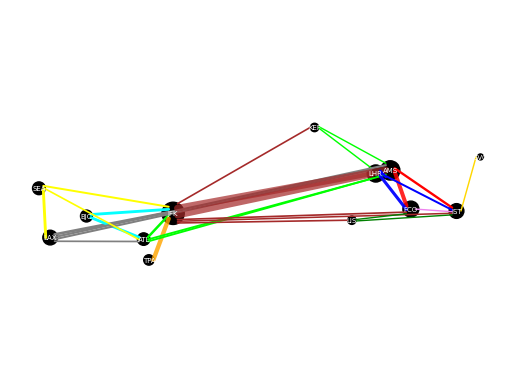

5.0

In [39]:
draw_weighted_graph(nodes, edges_norm, pos_norm)

In [40]:
# np.log1p(edge_matrix)

In [41]:
def test_weighted_graph(nodes, edges, positions):
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node)
    pos = positions

    x_values = [point[0] for point in pos.values()]
    plt.xlim(min(x_values) - 1, max(x_values) + 1)

    seg = (max(x_values) - min(x_values))/50
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            weight = edges[i][j]
            node1 = nodes[i]
            node2 = nodes[j]
            x1,y1 = pos[node1]
            x2,y2 = pos[node2]
            rise=(y2-y1)
            run=(x2-x1)-(seg*2)
            if run != 0:
                dir_exit = np.arctan2(rise, (-1*run))
                dir_enter = np.arctan2(-rise, -run) 
                if dir_exit < 0:
                    dir_exit += 2*np.pi
                if dir_enter < 0:
                    dir_enter += 2*np.pi
            elif y1 > y2:
                dir_exit = 3*np.pi/2
                dir_enter = np.pi/2
            else:
                dir_exit = np.pi/2
                dir_enter = 3*np.pi/2
            if weight != 0:
                G.add_edge(nodes[i], nodes[j], weight=weight, d1 = round(dir_exit,3), d2 = round(dir_enter,3))

    for node in G.nodes():
        successor_edges = sorted(G.edges(node, data=True), key=lambda x: x[2]['d1'])
        p1_counter = 0
        p2_counter = 0
        predecessor_edges = sorted(G.in_edges(node, data=True), key=lambda x: x[2]['d2'])
        for u, v, edge_data in successor_edges:
            G.edges[u, v]['p1'] = p1_counter
            p1_counter += 1
        for u, v, edge_data in predecessor_edges:
            G.edges[u, v]['p2'] = p2_counter
            p2_counter += 1

    out_edge_weights = {}
    in_edge_weights = {}
    for node in nodes:
        out_edge_weights[node] = sum(G.edges[edge]['weight'] for edge in G.edges() if edge[0] == node)
        in_edge_weights[node] = sum(G.edges[edge]['weight'] for edge in G.edges() if edge[1] == node)


    x_values = [point[0] for point in pos.values()]
    #plt.xlim(min(x_values) - 1, max(x_values) + 1)
    
    dim = max(x_values) - min(x_values)
    
    fact = 600/(dim)

    running_in_width = {node: 0 for node in nodes}
    running_out_width = {node: 0 for node in nodes}

    p1_counters = {node: 0 for node in nodes}
    p2_counters = {node: 0 for node in nodes}
    edges_placed = 0
    intersection_count = 0
    while edges_placed < len(G.edges()):
        for edge in G.edges():
            node1, node2 = edge

            if G.edges[edge]['p1'] == p1_counters[node1] and G.edges[edge]['p2'] == p2_counters[node2]:

                weight = G.edges[edge]['weight']
                x1, y1 = pos[node1]
                x2, y2 = pos[node2]
                seg = seg

                control_point = (x1 + seg / 2, y1 + out_edge_weights[node1]/fact-running_out_width[node1]/(fact/2)-weight/fact)
                control_point_2 = (x2 - seg / 2, y2 + in_edge_weights[node2]/fact-running_in_width[node2]/(fact/2)-weight/fact)



                #plt.plot([control_point[0], control_point_2[0]], [control_point[1], control_point_2[1]], color=color, linewidth=weight, alpha=min(1/weight+0.5, 1), solid_capstyle="round")

                for node in nodes:
                    if node != node1 and node != node2:
                        px, py = pos[node]
                        intersection_count += check_intersection(px, py, control_point[0], control_point[1], control_point_2[0], control_point_2[1], weight, out_edge_weights[node], dim)

                running_out_width[node1] += weight
                running_in_width[node2] += weight

                p1_counters[node1] += 1
                p2_counters[node2] += 1
                edges_placed += 1
    return intersection_count

def total_distance_moved(true_pos, plotted_pos):
    def euclidean_distance(point1, point2):
        return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5
    
    total_distance = 0.0
    for key in true_pos:
        total_distance += euclidean_distance(true_pos[key], plotted_pos[key])
    
    return total_distance

def check_order_preservation(pos1, pos2):
    switches = 0
    keys = list(pos1.keys())
        
    # Compare horizontal positions
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            key_i = keys[i]
            key_j = keys[j]
            # Check horizontal order in true_pos
            if (pos1[key_i][0] - pos1[key_j][0]) * (pos2[key_i][0] - pos2[key_j][0]) < 0:
                switches += 1
            elif abs(pos2[key_i][0] - pos2[key_j][0]) < abs(pos1[key_i][0] - pos1[key_j][0])/3:
                switches +=0.15
                
            # Check vertical order in true_pos
            if (pos1[key_i][1] - pos1[key_j][1]) * (pos2[key_i][1] - pos2[key_j][1]) < 0:
                switches += 1
            elif abs(pos2[key_i][1] - pos2[key_j][1]) < abs(pos1[key_i][1] - pos1[key_j][1])/5:
                switches +=0.15
        
    return switches

def node_spacing(pos):
    min_dist = 99999
    x_values = [point[0] for point in pos.values()]
    dim = max(x_values) - min(x_values)
    fact = (10/dim)
    for i in range(len(nodes)):
        for j in range(i+1,len(nodes)):

            dist = math.sqrt(fact *((pos[nodes[i]][0] - pos[nodes[j]][0]) ** 2 + (pos[nodes[i]][1] - pos[nodes[j]][1]) ** 2))
            if dist < min_dist:
                min_dist = dist
                
    return math.sqrt(min_dist)

def calculate_score(intersection_count, distance_moved, order_preserved, min_dist, dim, print_results = False):
    int_pen = -(intersection_count*15)
    dist_pen = ((-10*distance_moved)/dim)
    order_pen = (-order_preserved*8)
    spacing_pen = (min_dist*4)
    
    combined = int_pen + dist_pen + order_pen + spacing_pen
    if print_results:
        print('int_pen {},{}; dist_pen {},{}; order_pen {}, {}; spacing {}, {}; total {}'.format(intersection_count, int_pen, distance_moved, dist_pen, order_preserved, order_pen, min_dist, spacing_pen, combined))
    
    return combined

In [42]:
import random
    
def single_pass_algorithm(nodes, edges, pos, max_move, step):
    best_positions = copy.deepcopy(pos)
    best_score = -float('inf')
    
    moves = np.arange(-max_move, (max_move + .001), step)
    
    x_values = [point[0] for point in pos.values()]
    dim = max(x_values) - min(x_values)
    
    improved = False
    
    for node in nodes:
        local_best_score = -float('inf')
        local_best_pos = best_positions[node]
        
        for x in moves:
            for y in moves:
                if x == 0 and y == 0:
                    continue
                new_pos = copy.deepcopy(best_positions)
                new_pos[node] = (best_positions[node][0] + x, best_positions[node][1] + y)
                
                # Calculate metrics
                ints = test_weighted_graph(nodes, edges, new_pos)
                movement = total_distance_moved(pos, new_pos)
                order = check_order_preservation(pos, new_pos)
                min_dist = node_spacing(new_pos)
                
                # Calculate score based on metrics
                score = calculate_score(ints, movement, order, min_dist, dim)
                
                if score > local_best_score:
                    local_best_score = score
                    local_best_pos = new_pos[node]
        
        # Update the position if it improved
        if local_best_score > best_score:
            best_score = local_best_score
            best_positions[node] = local_best_pos
            improved = True

    ints = test_weighted_graph(nodes, edges, best_positions)
    movement = total_distance_moved(pos, best_positions)
    order = check_order_preservation(pos, best_positions)
    min_dist = node_spacing(best_positions)
    
    score = calculate_score(ints, movement, order, min_dist, dim, True)
    #print('############# Final score {} #############'.format(score))
    
    #print("Best positions after single pass algorithm:", best_positions)
    #print("Best score:", best_score)
    
    int_count = draw_weighted_graph(nodes, edges, best_positions)
    #print('Order changed: {}'.format(check_order_preservation(pos, best_positions)))
    #print('Distance Moved: {}'.format(total_distance_moved(pos, best_positions)))
    #print('closest nodes {}'.format(node_spacing(best_positions)))
    order_pres = check_order_preservation(pos, best_positions)
    total_dist = total_distance_moved(pos, best_positions)
    space = node_spacing(best_positions)
    return int_count, total_dist, order_pres, space, score

def iterative_algorithm(nodes, edges, pos, max_move, step, iterations=10):
    best_positions = copy.deepcopy(pos)
    best_score = -float('inf')
    
    moves = np.arange(-max_move, (max_move+.001), step)
    
    x_values = [point[0] for point in pos.values()]
    dim = max(x_values) - min(x_values)
    
    for it in range(iterations):
        improved = 0
        for node in nodes:
            local_best_score = -float('inf')
            local_best_pos = best_positions[node]
            
            for x in moves:
                for y in moves:
                    if x == 0 and y == 0:
                        continue
                    new_pos = copy.deepcopy(best_positions)
                    new_pos[node] = (best_positions[node][0] + x, best_positions[node][1] + y)
                    
                    # Calculate metrics
                    ints = test_weighted_graph(nodes, edges, new_pos)
                    movement = total_distance_moved(pos, new_pos)
                    order = check_order_preservation(pos, new_pos)
                    min_dist = node_spacing(new_pos)
                    # Calculate score based on metrics
                    score = calculate_score(ints, movement, order, min_dist, dim)
                    
                    if score > local_best_score:
                        local_best_score = score
                        local_best_pos = new_pos[node]
            
            # Update the position if it improved
            if local_best_score > best_score:
                improved = local_best_score - best_score
                best_score = local_best_score
                best_positions[node] = local_best_pos
                
                
        ints = test_weighted_graph(nodes, edges, best_positions)
        movement = total_distance_moved(pos, best_positions)
        order = check_order_preservation(pos, best_positions)
        min_dist = node_spacing(best_positions)
        
        score = calculate_score(ints, movement, order, min_dist, dim, True)
        print('#############iter {}, score {}#############'.format(it, score))
        if  improved < 0.1:
            break
    
    print("Best positions after hybrid algorithm:", best_positions)
    print("Best score:", best_score)
    
    int_count = draw_weighted_graph(nodes, edges, best_positions)
    print('Order changed: {}'.format(check_order_preservation(pos, best_positions)))
    print('Distance Moved: {}'.format(total_distance_moved(pos, best_positions)))
    print('closest nodes {}'.format(node_spacing(best_positions)))
    order_pres = check_order_preservation(pos, best_positions)
    total_dist = total_distance_moved(pos, best_positions)
    space = node_spacing(best_positions)
    return int_count, total_dist, order_pres, space, score

Iteration: 0.5
int_pen 1.5,-22.5; dist_pen 3.1213203435596424,-2.0808802290397614; order_pen 1.15, -9.2; spacing 0.7029070075383598, 2.811628030153439; total -30.96925219888632
Total intersections: 1.5


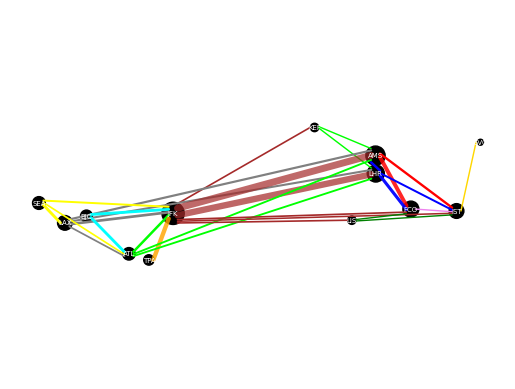

Iteration: 0.25
int_pen 0.75,-11.25; dist_pen 2.3251407699364424,-1.550093846624295; order_pen 1.15, -9.2; spacing 0.2934641372477799, 1.1738565489911197; total -20.826237297633178
Total intersections: 0.75


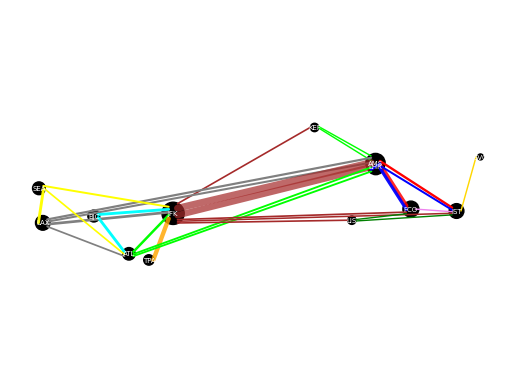

Iteration: 0.16666666666666666
int_pen 1.25,-18.75; dist_pen 2.818781177471543,-1.8791874516476954; order_pen 1, -8; spacing 0.826630223694093, 3.306520894776372; total -25.322666556871322
Total intersections: 1.25


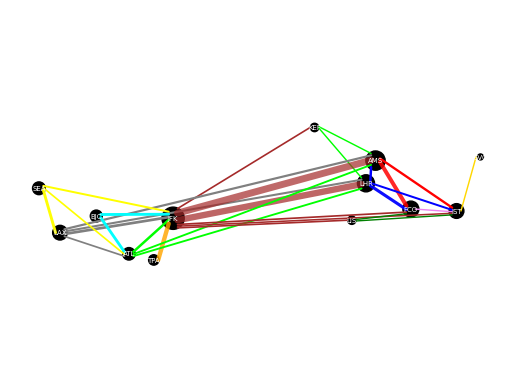

Iteration: 0.125
int_pen 1.0,-15.0; dist_pen 1.9231888938217538,-1.2821259292145024; order_pen 0.3, -2.4; spacing 0.5521211291349298, 2.2084845165397193; total -16.47364141267478
Total intersections: 1.0


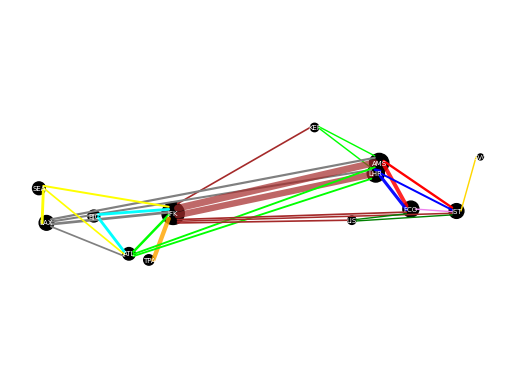

Iteration: 0.1
int_pen 0.75,-11.25; dist_pen 1.2708203932499356,-0.847213595499957; order_pen 0.15, -1.2; spacing 0.5821219868636454, 2.3284879474545814; total -10.968725648045375
Total intersections: 0.75


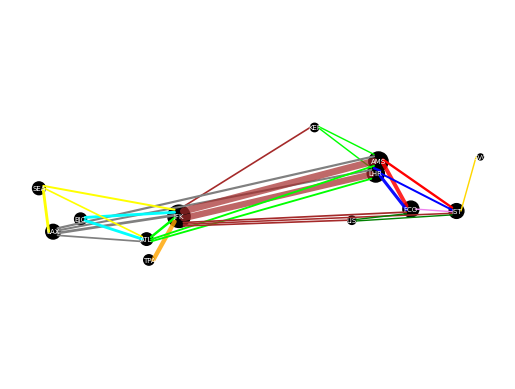

[1.5, 0.75, 1.25, 1.0, 0.75]
[3.1213203435596424, 2.3251407699364424, 2.818781177471543, 1.9231888938217538, 1.2708203932499356]
[1.15, 1.15, 1, 0.3, 0.15]
[0.7029070075383598, 0.2934641372477799, 0.826630223694093, 0.5521211291349298, 0.5821219868636454]
[0.7307837009429932, 1.4900717735290527, 3.5241775512695312, 4.987928152084351, 8.232903480529785]
[-30.96925219888632, -20.826237297633178, -25.322666556871322, -16.47364141267478, -10.968725648045375]
   Step Size  Intersections  Distances  Orders  Spacings     Times     Scores
0   0.500000           1.50   3.121320    1.15  0.702907  0.730784 -30.969252
1   0.250000           0.75   2.325141    1.15  0.293464  1.490072 -20.826237
2   0.166667           1.25   2.818781    1.00  0.826630  3.524178 -25.322667
3   0.125000           1.00   1.923189    0.30  0.552121  4.987928 -16.473641
4   0.100000           0.75   1.270820    0.15  0.582122  8.232903 -10.968726


In [43]:
#################### Test Multiple Trials ######################3
num_trials = 10
step_sizes = [0.5,0.25,1/6, 0.125, 0.1]
intersections = []
distances = []
orders = []
spacings = []
times = []
scores = []
for j in step_sizes:
    print('Iteration: {}'.format(j))
    start_time = time.time()
    
    i,d,o,s,sc = single_pass_algorithm(nodes, edges_norm, pos_norm, 0.5, j)
    # i,d,o,s,sc = iterative_algorithm(nodes, edges_norm, pos_norm, 0.5, j)
    
    end_time = time.time()
    execution_time = end_time - start_time    
    intersections.append(i)
    distances.append(d)
    orders.append(o)
    spacings.append(s)
    times.append(execution_time)
    scores.append(sc)

print(intersections)
print(distances)
print(orders)
print(spacings)
print(times)
print(scores)

data = {
    'Step Size': step_sizes,
    'Intersections': intersections,
    'Distances': distances,
    'Orders': orders,
    'Spacings': spacings,
    'Times': times,
    'Scores': scores
}

df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)
#print(df.mean())


In [44]:
# Select only specific starting locations
trajectories = trajectory_data.filterOnStartPoints(['SEA', 'LAX'])
edge_matrix = trajectory_data.constructWeightMatrix(trajectories=trajectories)

# Normalize edges
edges_norm = min_max_scaling(edge_matrix, 1, 5)

# Edges with value 0 should remain 0
for i, j in zip(np.where(edge_matrix == 0)[0], np.where(edge_matrix == 0)[1]):
    edges_norm[i, j] = 0

Constructing weight matrix ...


100%|██████████| 181681/181681 [00:46<00:00, 3910.51it/s]

Done!


Total intersections: 4.75


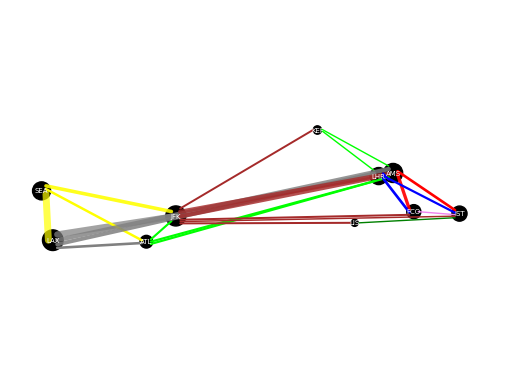

4.75

In [45]:
draw_weighted_graph(nodes, edges_norm, pos_norm)

Iteration: 0.5
int_pen 1.0,-15.0; dist_pen 2.621320343559643,-1.7475468957064284; order_pen 0.3, -2.4; spacing 0.7720587156163464, 3.0882348624653857; total -16.059312033241042
#############iter 0, score -16.059312033241042#############
int_pen 1.0,-15.0; dist_pen 2.621320343559643,-1.7475468957064284; order_pen 0.3, -2.4; spacing 0.7720587156163464, 3.0882348624653857; total -16.059312033241042
#############iter 1, score -16.059312033241042#############
Best positions after hybrid algorithm: {'LAX': (-9.118236022581495, 3.2594631881820026), 'JFK': (-5.442376428795476, 3.582956776768381), 'ATL': (-6.44250352327175, 2.708030028245214), 'BJC': (-8.385518241813832, 3.4915222698376107), 'SEA': (-10.0, 4.433925084916167), 'TPA': (-6.264596299735104, 2.0), 'LHR': (0.943621078149329, 4.436314957743271), 'FCO': (2.6356389189581773, 3.727807232663354), 'SVO': (5.0, 5.999044606330593), 'AMS': (1.4340868011447263, 5.541359658502309), 'IST': (4.186438831557245, 3.6622308442180627), 'KEF': (-0.6366

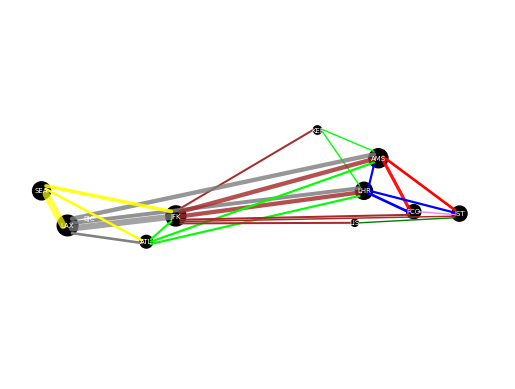

Order changed: 0.3
Distance Moved: 2.621320343559643
closest nodes 0.7720587156163464
Iteration: 0.25
int_pen 1.0,-15.0; dist_pen 1.4715873793431686,-0.9810582528954458; order_pen 0.15, -1.2; spacing 0.7291112013033274, 2.9164448052133096; total -14.264613447682137
#############iter 0, score -14.264613447682137#############
int_pen 0.75,-11.25; dist_pen 1.7215873793431686,-1.1477249195621124; order_pen 0.15, -1.2; spacing 0.7291112013033274, 2.9164448052133096; total -10.681280114348802
#############iter 1, score -10.681280114348802#############
int_pen 0.75,-11.25; dist_pen 1.7215873793431686,-1.1477249195621124; order_pen 0.15, -1.2; spacing 0.7291112013033274, 2.9164448052133096; total -10.681280114348802
#############iter 2, score -10.681280114348802#############
Best positions after hybrid algorithm: {'LAX': (-9.868236022581495, 3.2594631881820026), 'JFK': (-5.442376428795476, 3.582956776768381), 'ATL': (-6.44250352327175, 2.708030028245214), 'BJC': (-8.135518241813832, 3.49152226

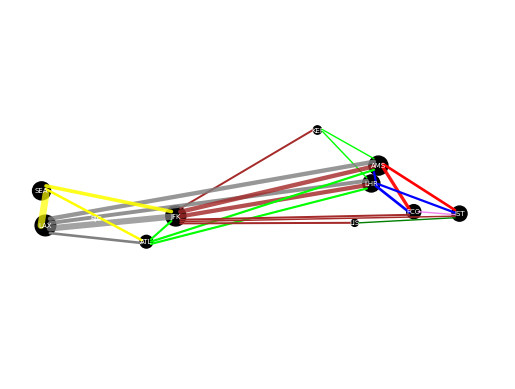

Order changed: 0.15
Distance Moved: 1.7215873793431686
closest nodes 0.7291112013033274
Iteration: 0.16666666666666666
int_pen 0.5,-7.5; dist_pen 2.339921612612362,-1.5599477417415746; order_pen 1.15, -9.2; spacing 0.900285452585381, 3.601141810341524; total -14.65880593140005
#############iter 0, score -14.65880593140005#############
int_pen 1.0,-15.0; dist_pen 2.1732549459456956,-1.4488366306304636; order_pen 0.15, -1.2; spacing 0.900285452585381, 3.601141810341524; total -14.047694820288939
#############iter 1, score -14.047694820288939#############
int_pen 1.0,-15.0; dist_pen 2.1732549459456956,-1.4488366306304636; order_pen 0.15, -1.2; spacing 0.900285452585381, 3.601141810341524; total -14.047694820288939
#############iter 2, score -14.047694820288939#############
Best positions after hybrid algorithm: {'LAX': (-9.95156935591483, 3.0927965215153357), 'JFK': (-5.442376428795476, 3.582956776768381), 'ATL': (-6.44250352327175, 2.708030028245214), 'BJC': (-8.385518241813832, 3.491522

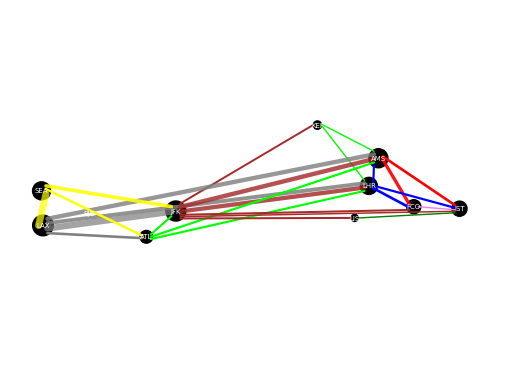

Order changed: 0.15
Distance Moved: 2.1732549459456956
closest nodes 0.900285452585381
Iteration: 0.125
int_pen 0.5,-7.5; dist_pen 1.5558963160534711,-1.037264210702314; order_pen 1.15, -9.2; spacing 0.7720587156163464, 3.0882348624653857; total -14.649029348236928
#############iter 0, score -14.649029348236928#############
int_pen 0.5,-7.5; dist_pen 1.6808963160534711,-1.1205975440356473; order_pen 0.3, -2.4; spacing 0.7720587156163464, 3.0882348624653857; total -7.932362681570261
#############iter 1, score -7.932362681570261#############
int_pen 0.5,-7.5; dist_pen 1.6808963160534711,-1.1205975440356473; order_pen 0.3, -2.4; spacing 0.7720587156163464, 3.0882348624653857; total -7.932362681570261
#############iter 2, score -7.932362681570261#############
Best positions after hybrid algorithm: {'LAX': (-9.868236022581495, 3.1344631881820026), 'JFK': (-5.442376428795476, 3.457956776768381), 'ATL': (-6.44250352327175, 2.708030028245214), 'BJC': (-8.135518241813832, 3.3665222698376107), '

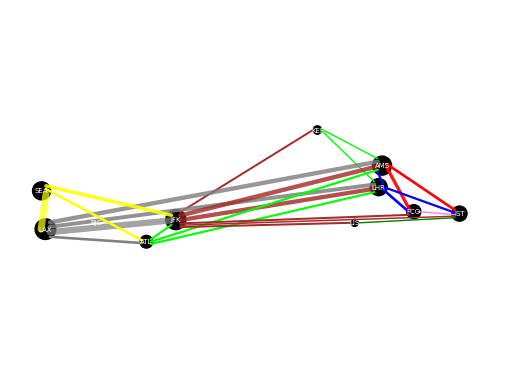

Order changed: 0.3
Distance Moved: 1.6808963160534711
closest nodes 0.7720587156163464
Iteration: 0.1
int_pen 0.5,-7.5; dist_pen 1.5242640687119289,-1.0161760458079525; order_pen 1.2999999999999998, -10.399999999999999; spacing 0.7618307703706629, 3.0473230814826517; total -15.8688529643253
#############iter 0, score -15.8688529643253#############
int_pen 0.5,-7.5; dist_pen 1.724264068711929,-1.149509379141286; order_pen 0.3, -2.4; spacing 0.7618307703706629, 3.0473230814826517; total -8.002186297658634
#############iter 1, score -8.002186297658634#############
int_pen 0.5,-7.5; dist_pen 1.724264068711929,-1.149509379141286; order_pen 0.3, -2.4; spacing 0.7618307703706629, 3.0473230814826517; total -8.002186297658634
#############iter 2, score -8.002186297658634#############
Best positions after hybrid algorithm: {'LAX': (-9.918236022581496, 3.0594631881820025), 'JFK': (-5.442376428795476, 3.382956776768381), 'ATL': (-6.44250352327175, 2.708030028245214), 'BJC': (-8.385518241813832, 3.

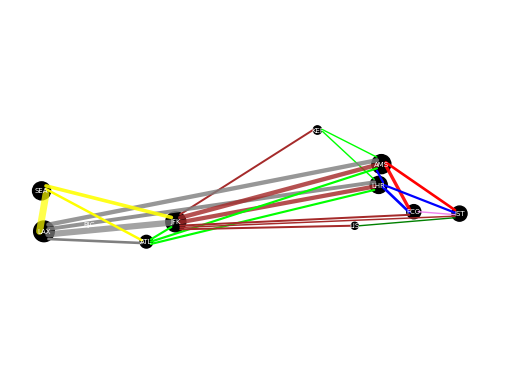

Order changed: 0.3
Distance Moved: 1.724264068711929
closest nodes 0.7618307703706629
[1.0, 0.75, 1.0, 0.5, 0.5]
[2.621320343559643, 1.7215873793431686, 2.1732549459456956, 1.6808963160534711, 1.724264068711929]
[0.3, 0.15, 0.15, 0.3, 0.3]
[0.7720587156163464, 0.7291112013033274, 0.900285452585381, 0.7720587156163464, 0.7618307703706629]
[1.0851428508758545, 3.592428207397461, 7.350646734237671, 11.370129108428955, 19.03179955482483]
[-16.059312033241042, -10.681280114348802, -14.047694820288939, -7.932362681570261, -8.002186297658634]
   Step Size  Intersections  Distances  Orders  Spacings      Times     Scores
0   0.500000           1.00   2.621320    0.30  0.772059   1.085143 -16.059312
1   0.250000           0.75   1.721587    0.15  0.729111   3.592428 -10.681280
2   0.166667           1.00   2.173255    0.15  0.900285   7.350647 -14.047695
3   0.125000           0.50   1.680896    0.30  0.772059  11.370129  -7.932363
4   0.100000           0.50   1.724264    0.30  0.761831  19.03

In [46]:
#################### Test Multiple Trials ######################3
num_trials = 10
step_sizes = [0.5,0.25,1/6, 0.125, 0.1]
intersections = []
distances = []
orders = []
spacings = []
times = []
scores = []
for j in step_sizes:
    print('Iteration: {}'.format(j))
    start_time = time.time()
    
    # i,d,o,s,sc = single_pass_algorithm(nodes, edges_norm, pos_norm, 0.5, j)
    i,d,o,s,sc = iterative_algorithm(nodes, edges_norm, pos_norm, 0.5, j)
    
    end_time = time.time()
    execution_time = end_time - start_time    
    intersections.append(i)
    distances.append(d)
    orders.append(o)
    spacings.append(s)
    times.append(execution_time)
    scores.append(sc)

print(intersections)
print(distances)
print(orders)
print(spacings)
print(times)
print(scores)

data = {
    'Step Size': step_sizes,
    'Intersections': intersections,
    'Distances': distances,
    'Orders': orders,
    'Spacings': spacings,
    'Times': times,
    'Scores': scores
}

df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)
#print(df.mean())


In [47]:
# Select only specific starting locations
trajectories = trajectory_data.filterOnIntermediatePoints(['LHR', 'AMS'])
edge_matrix = trajectory_data.constructWeightMatrix(trajectories=trajectories)

# Normalize edges
edges_norm = min_max_scaling(edge_matrix, 1, 5)

# Edges with value 0 should remain 0
for i, j in zip(np.where(edge_matrix == 0)[0], np.where(edge_matrix == 0)[1]):
    edges_norm[i, j] = 0

Constructing weight matrix ...


100%|██████████| 319209/319209 [01:40<00:00, 3168.91it/s]

Done!


Total intersections: 6.0


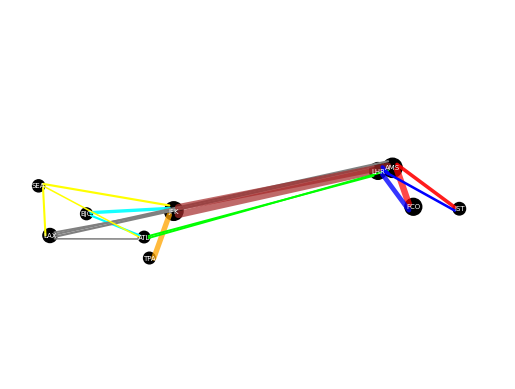

6.0

In [48]:
draw_weighted_graph(nodes, edges_norm, pos_norm)

Iteration: 0.5
int_pen 1.0,-15.0; dist_pen 4.121320343559643,-2.7475468957064284; order_pen 0.15, -1.2; spacing 0.7609103553027502, 3.043641421211001; total -15.903905474495426
#############iter 0, score -15.903905474495426#############
int_pen 1.0,-15.0; dist_pen 4.121320343559643,-2.7475468957064284; order_pen 0.15, -1.2; spacing 0.7609103553027502, 3.043641421211001; total -15.903905474495426
#############iter 1, score -15.903905474495426#############
Best positions after hybrid algorithm: {'LAX': (-9.618236022581495, 3.2594631881820026), 'JFK': (-4.942376428795476, 3.582956776768381), 'ATL': (-6.94250352327175, 2.208030028245214), 'BJC': (-8.385518241813832, 3.4915222698376107), 'SEA': (-10.0, 3.933925084916167), 'TPA': (-6.264596299735104, 2.0), 'LHR': (0.943621078149329, 4.436314957743271), 'FCO': (2.6356389189581773, 3.727807232663354), 'SVO': (5.0, 5.999044606330593), 'AMS': (1.4340868011447263, 5.541359658502309), 'IST': (4.186438831557245, 3.6622308442180627), 'KEF': (-0.6366

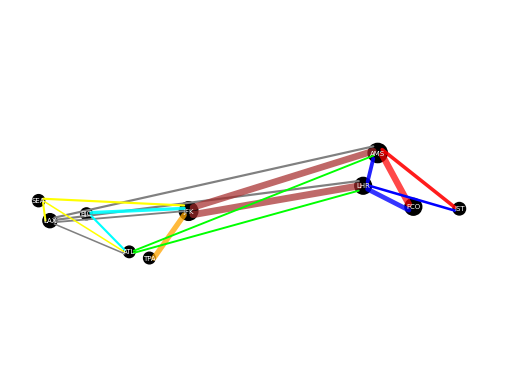

Order changed: 0.15
Distance Moved: 4.121320343559643
closest nodes 0.7609103553027502
Iteration: 0.25
int_pen 0.75,-11.25; dist_pen 2.5751407699364424,-1.7167605132909616; order_pen 1, -8; spacing 0.5385139641772138, 2.154055856708855; total -18.812704656582106
#############iter 0, score -18.812704656582106#############
int_pen 0.75,-11.25; dist_pen 2.5751407699364424,-1.7167605132909616; order_pen 1, -8; spacing 0.5385139641772138, 2.154055856708855; total -18.812704656582106
#############iter 1, score -18.812704656582106#############
Best positions after hybrid algorithm: {'LAX': (-9.118236022581495, 3.0094631881820026), 'JFK': (-4.942376428795476, 3.582956776768381), 'ATL': (-6.94250352327175, 2.208030028245214), 'BJC': (-8.135518241813832, 3.4915222698376107), 'SEA': (-10.0, 4.433925084916167), 'TPA': (-6.264596299735104, 2.0), 'LHR': (1.443621078149329, 4.936314957743271), 'FCO': (2.6356389189581773, 3.727807232663354), 'SVO': (5.0, 5.499044606330593), 'AMS': (1.4340868011447263,

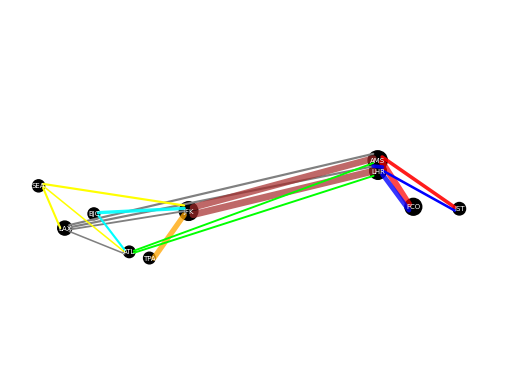

Order changed: 1
Distance Moved: 2.5751407699364424
closest nodes 0.5385139641772138
Iteration: 0.16666666666666666
int_pen 0.5,-7.5; dist_pen 2.9089572063412095,-1.939304804227473; order_pen 1, -8; spacing 0.2934641372477799, 1.1738565489911197; total -16.265448255236354
#############iter 0, score -16.265448255236354#############
int_pen 0.5,-7.5; dist_pen 2.7422905396745425,-1.8281936931163616; order_pen 1, -8; spacing 0.2934641372477799, 1.1738565489911197; total -16.154337144125243
#############iter 1, score -16.154337144125243#############
int_pen 0.5,-7.5; dist_pen 2.7422905396745425,-1.8281936931163616; order_pen 1, -8; spacing 0.2934641372477799, 1.1738565489911197; total -16.154337144125243
#############iter 2, score -16.154337144125243#############
Best positions after hybrid algorithm: {'LAX': (-9.118236022581495, 3.0927965215153357), 'JFK': (-5.109043095462143, 3.582956776768381), 'ATL': (-6.94250352327175, 2.208030028245214), 'BJC': (-8.218851575147166, 3.4915222698376107)

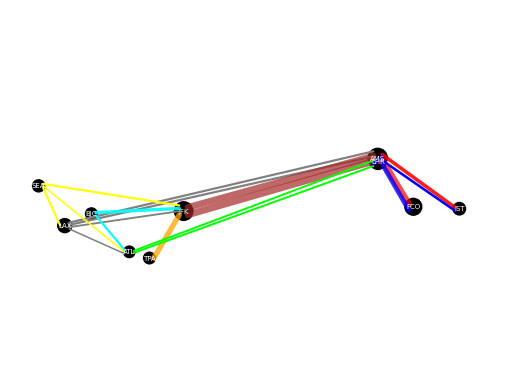

Order changed: 1
Distance Moved: 2.7422905396745425
closest nodes 0.2934641372477799
Iteration: 0.125
int_pen 0.75,-11.25; dist_pen 2.4810239953229094,-1.6540159968819395; order_pen 0.15, -1.2; spacing 0.6349281568252262, 2.5397126273009047; total -11.564303369581035
#############iter 0, score -11.564303369581035#############
int_pen 0.75,-11.25; dist_pen 2.3560239953229094,-1.5706826635486062; order_pen 0.15, -1.2; spacing 0.6349281568252262, 2.5397126273009047; total -11.480970036247701
#############iter 1, score -11.480970036247701#############
Best positions after hybrid algorithm: {'LAX': (-9.243236022581495, 3.0094631881820026), 'JFK': (-5.067376428795476, 3.582956776768381), 'ATL': (-6.81750352327175, 2.208030028245214), 'BJC': (-8.135518241813832, 3.4915222698376107), 'SEA': (-10.0, 4.433925084916167), 'TPA': (-6.264596299735104, 2.0), 'LHR': (1.443621078149329, 4.936314957743271), 'FCO': (2.6356389189581773, 3.727807232663354), 'SVO': (5.0, 5.624044606330593), 'AMS': (1.559086

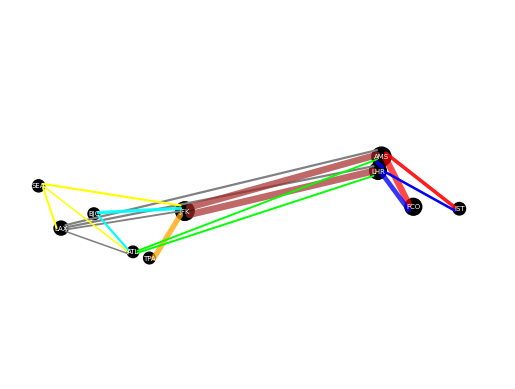

Order changed: 0.15
Distance Moved: 2.3560239953229094
closest nodes 0.6349281568252262
Iteration: 0.1
int_pen 0.5,-7.5; dist_pen 2.001602785260981,-1.334401856840654; order_pen 0.15, -1.2; spacing 0.7067591643643532, 2.8270366574574126; total -7.20736519938324
#############iter 0, score -7.20736519938324#############
int_pen 0.5,-7.5; dist_pen 1.901602785260981,-1.2677351901739873; order_pen 0.15, -1.2; spacing 0.7067591643643532, 2.8270366574574126; total -7.1406985327165735
#############iter 1, score -7.1406985327165735#############
Best positions after hybrid algorithm: {'LAX': (-9.218236022581495, 3.0594631881820025), 'JFK': (-5.042376428795476, 3.482956776768381), 'ATL': (-6.44250352327175, 2.708030028245214), 'BJC': (-8.585518241813832, 3.3915222698376106), 'SEA': (-10.0, 4.433925084916167), 'TPA': (-6.264596299735104, 2.0), 'LHR': (1.443621078149329, 4.836314957743271), 'FCO': (2.6356389189581773, 3.727807232663354), 'SVO': (5.0, 5.599044606330593), 'AMS': (1.5340868011447264, 

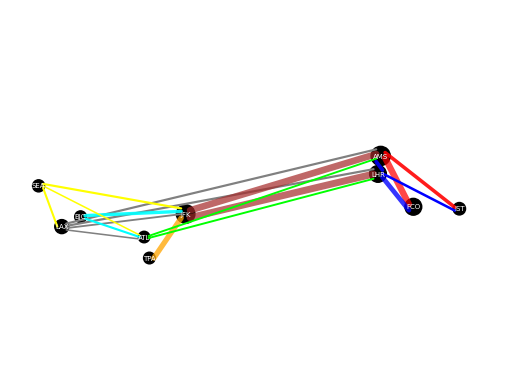

Order changed: 0.15
Distance Moved: 1.901602785260981
closest nodes 0.7067591643643532
[1.0, 0.75, 0.5, 0.75, 0.5]
[4.121320343559643, 2.5751407699364424, 2.7422905396745425, 2.3560239953229094, 1.901602785260981]
[0.15, 1, 1, 0.15, 0.15]
[0.7609103553027502, 0.5385139641772138, 0.2934641372477799, 0.6349281568252262, 0.7067591643643532]
[1.0113615989685059, 2.3984568119049072, 7.6777002811431885, 8.267436981201172, 11.129807710647583]
[-15.903905474495426, -18.812704656582106, -16.154337144125243, -11.480970036247701, -7.1406985327165735]
   Step Size  Intersections  Distances  Orders  Spacings      Times     Scores
0   0.500000           1.00   4.121320    0.15  0.760910   1.011362 -15.903905
1   0.250000           0.75   2.575141    1.00  0.538514   2.398457 -18.812705
2   0.166667           0.50   2.742291    1.00  0.293464   7.677700 -16.154337
3   0.125000           0.75   2.356024    0.15  0.634928   8.267437 -11.480970
4   0.100000           0.50   1.901603    0.15  0.706759  1

In [49]:
#################### Test Multiple Trials ######################3
num_trials = 10
step_sizes = [0.5,0.25,1/6, 0.125, 0.1]
intersections = []
distances = []
orders = []
spacings = []
times = []
scores = []
for j in step_sizes:
    print('Iteration: {}'.format(j))
    start_time = time.time()
    
    # i,d,o,s,sc = single_pass_algorithm(nodes, edges_norm, pos_norm, 0.5, j)
    i,d,o,s,sc = iterative_algorithm(nodes, edges_norm, pos_norm, 0.5, j)
    
    end_time = time.time()
    execution_time = end_time - start_time    
    intersections.append(i)
    distances.append(d)
    orders.append(o)
    spacings.append(s)
    times.append(execution_time)
    scores.append(sc)

print(intersections)
print(distances)
print(orders)
print(spacings)
print(times)
print(scores)

data = {
    'Step Size': step_sizes,
    'Intersections': intersections,
    'Distances': distances,
    'Orders': orders,
    'Spacings': spacings,
    'Times': times,
    'Scores': scores
}

df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)
#print(df.mean())


In [50]:
# Select only specific starting locations
trajectories = trajectory_data.filterOnEndPoints(['FCO', 'IST', 'SVO'])
edge_matrix = trajectory_data.constructWeightMatrix(trajectories=trajectories)

# Normalize edges
edges_norm = min_max_scaling(edge_matrix, 1, 5)

# Edges with value 0 should remain 0
for i, j in zip(np.where(edge_matrix == 0)[0], np.where(edge_matrix == 0)[1]):
    edges_norm[i, j] = 0

Constructing weight matrix ...


100%|██████████| 292167/292167 [01:24<00:00, 3471.73it/s]

Done!


Total intersections: 5.0


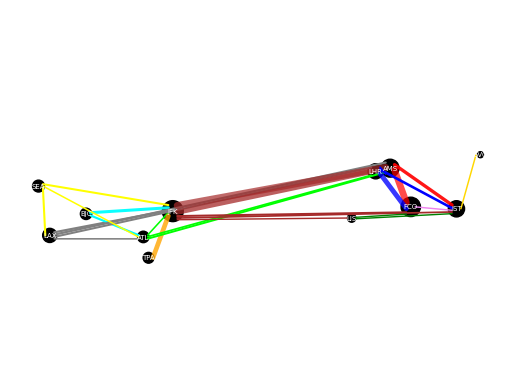

5.0

In [51]:
draw_weighted_graph(nodes, edges_norm, pos_norm)

Iteration: 0.5
int_pen 1.25,-18.75; dist_pen 3.6213203435596424,-2.414213562373095; order_pen 0.15, -1.2; spacing 0.7609103553027502, 3.043641421211001; total -19.320572141162096
#############iter 0, score -19.320572141162096#############
int_pen 1.25,-18.75; dist_pen 3.2071067811865475,-2.1380711874576983; order_pen 0.15, -1.2; spacing 0.7609103553027502, 3.043641421211001; total -19.044429766246697
#############iter 1, score -19.044429766246697#############
int_pen 1.25,-18.75; dist_pen 3.2071067811865475,-2.1380711874576983; order_pen 0.15, -1.2; spacing 0.7609103553027502, 3.043641421211001; total -19.044429766246697
#############iter 2, score -19.044429766246697#############
Best positions after hybrid algorithm: {'LAX': (-9.618236022581495, 3.2594631881820026), 'JFK': (-5.442376428795476, 3.582956776768381), 'ATL': (-6.94250352327175, 2.208030028245214), 'BJC': (-8.385518241813832, 3.4915222698376107), 'SEA': (-10.0, 3.933925084916167), 'TPA': (-6.264596299735104, 2.0), 'LHR': (1

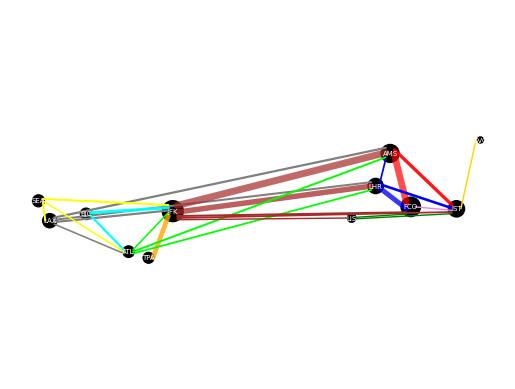

Order changed: 0.15
Distance Moved: 3.2071067811865475
closest nodes 0.7609103553027502
Iteration: 0.25
int_pen 0.75,-11.25; dist_pen 2.3251407699364424,-1.550093846624295; order_pen 1.15, -9.2; spacing 0.2934641372477799, 1.1738565489911197; total -20.826237297633178
#############iter 0, score -20.826237297633178#############
int_pen 0.75,-11.25; dist_pen 2.3251407699364424,-1.550093846624295; order_pen 1.15, -9.2; spacing 0.2934641372477799, 1.1738565489911197; total -20.826237297633178
#############iter 1, score -20.826237297633178#############
Best positions after hybrid algorithm: {'LAX': (-9.868236022581495, 3.2594631881820026), 'JFK': (-5.442376428795476, 3.582956776768381), 'ATL': (-6.94250352327175, 2.208030028245214), 'BJC': (-8.135518241813832, 3.4915222698376107), 'SEA': (-10.0, 4.433925084916167), 'TPA': (-6.264596299735104, 2.0), 'LHR': (1.443621078149329, 5.186314957743271), 'FCO': (2.6356389189581773, 3.727807232663354), 'SVO': (5.0, 5.499044606330593), 'AMS': (1.434086

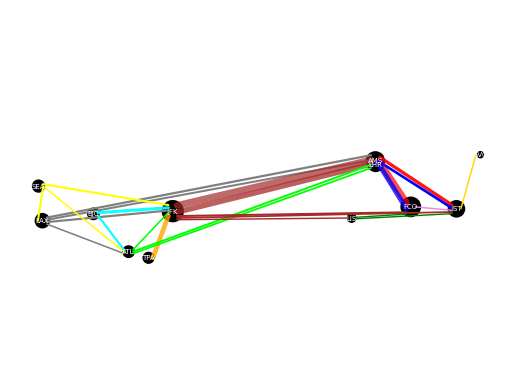

Order changed: 1.15
Distance Moved: 2.3251407699364424
closest nodes 0.2934641372477799
Iteration: 0.16666666666666666
int_pen 1.0,-15.0; dist_pen 2.0622300351827265,-1.3748200234551509; order_pen 2, -16; spacing 0.5983467311607955, 2.393386924643182; total -29.98143309881197
#############iter 0, score -29.98143309881197#############
int_pen 0.75,-11.25; dist_pen 2.3841913539371884,-1.5894609026247923; order_pen 2, -16; spacing 0.5983467311607955, 2.393386924643182; total -26.446073977981612
#############iter 1, score -26.446073977981612#############
int_pen 0.75,-11.25; dist_pen 2.3841913539371884,-1.5894609026247923; order_pen 2, -16; spacing 0.5983467311607955, 2.393386924643182; total -26.446073977981612
#############iter 2, score -26.446073977981612#############
Best positions after hybrid algorithm: {'LAX': (-9.618236022581495, 2.7594631881820026), 'JFK': (-4.942376428795476, 3.4162901101017145), 'ATL': (-6.609170189938416, 2.041363361578547), 'BJC': (-8.052184908480498, 3.491522

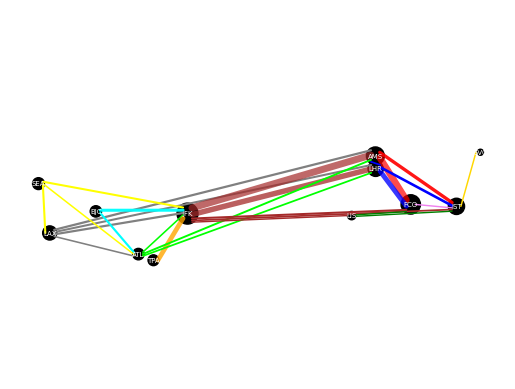

Order changed: 2
Distance Moved: 2.3841913539371884
closest nodes 0.5983467311607955
Iteration: 0.125
int_pen 0.75,-11.25; dist_pen 2.0263878188659974,-1.3509252125773314; order_pen 1.15, -9.2; spacing 0.6349281568252262, 2.5397126273009047; total -19.26121258527643
#############iter 0, score -19.26121258527643#############
int_pen 0.5,-7.5; dist_pen 1.8977553122506832,-1.2651702081671223; order_pen 1.15, -9.2; spacing 0.6349281568252262, 2.5397126273009047; total -15.425457580866219
#############iter 1, score -15.425457580866219#############
int_pen 0.5,-7.5; dist_pen 1.8030853981405939,-1.2020569320937293; order_pen 1.15, -9.2; spacing 0.6349281568252262, 2.5397126273009047; total -15.362344304792824
#############iter 2, score -15.362344304792824#############
Best positions after hybrid algorithm: {'LAX': (-9.493236022581495, 3.1344631881820026), 'JFK': (-5.442376428795476, 3.457956776768381), 'ATL': (-6.81750352327175, 2.333030028245214), 'BJC': (-8.260518241813832, 3.61652226983761

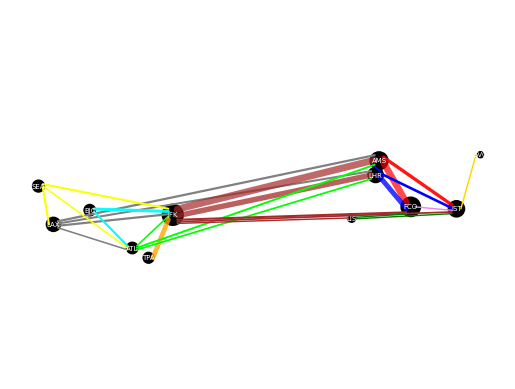

Order changed: 1.15
Distance Moved: 1.8030853981405939
closest nodes 0.6349281568252262
Iteration: 0.1
int_pen 0.75,-11.25; dist_pen 1.2886349517372662,-0.859089967824844; order_pen 0.15, -1.2; spacing 0.6472484381012206, 2.5889937524048823; total -10.72009621541996
#############iter 0, score -10.72009621541996#############
int_pen 0.75,-11.25; dist_pen 1.2886349517372662,-0.859089967824844; order_pen 0.15, -1.2; spacing 0.6472484381012206, 2.5889937524048823; total -10.72009621541996
#############iter 1, score -10.72009621541996#############
Best positions after hybrid algorithm: {'LAX': (-9.518236022581496, 2.9594631881820024), 'JFK': (-5.242376428795476, 3.482956776768381), 'ATL': (-6.34250352327175, 2.708030028245214), 'BJC': (-8.485518241813832, 3.3915222698376106), 'SEA': (-10.0, 4.433925084916167), 'TPA': (-6.264596299735104, 2.0), 'LHR': (1.443621078149329, 4.836314957743271), 'FCO': (2.6356389189581773, 3.727807232663354), 'SVO': (5.0, 5.499044606330593), 'AMS': (1.53408680114

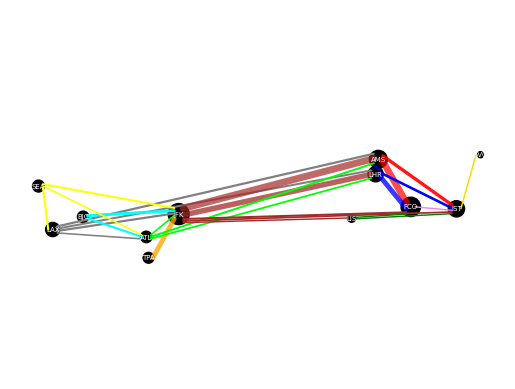

Order changed: 0.15
Distance Moved: 1.2886349517372662
closest nodes 0.6472484381012206
[1.25, 0.75, 0.75, 0.5, 0.75]
[3.2071067811865475, 2.3251407699364424, 2.3841913539371884, 1.8030853981405939, 1.2886349517372662]
[0.15, 1.15, 2, 1.15, 0.15]
[0.7609103553027502, 0.2934641372477799, 0.5983467311607955, 0.6349281568252262, 0.6472484381012206]
[1.580043077468872, 2.760941982269287, 8.335715770721436, 13.931412696838379, 13.818294048309326]
[-19.044429766246697, -20.826237297633178, -26.446073977981612, -15.362344304792824, -10.72009621541996]
   Step Size  Intersections  Distances  Orders  Spacings      Times     Scores
0   0.500000           1.25   3.207107    0.15  0.760910   1.580043 -19.044430
1   0.250000           0.75   2.325141    1.15  0.293464   2.760942 -20.826237
2   0.166667           0.75   2.384191    2.00  0.598347   8.335716 -26.446074
3   0.125000           0.50   1.803085    1.15  0.634928  13.931413 -15.362344
4   0.100000           0.75   1.288635    0.15  0.6472

In [52]:
#################### Test Multiple Trials ######################3
num_trials = 10
step_sizes = [0.5,0.25,1/6, 0.125, 0.1]
intersections = []
distances = []
orders = []
spacings = []
times = []
scores = []
for j in step_sizes:
    print('Iteration: {}'.format(j))
    start_time = time.time()
    
    # i,d,o,s,sc = single_pass_algorithm(nodes, edges_norm, pos_norm, 0.5, j)
    i,d,o,s,sc = iterative_algorithm(nodes, edges_norm, pos_norm, 0.5, j)
    
    end_time = time.time()
    execution_time = end_time - start_time    
    intersections.append(i)
    distances.append(d)
    orders.append(o)
    spacings.append(s)
    times.append(execution_time)
    scores.append(sc)

print(intersections)
print(distances)
print(orders)
print(spacings)
print(times)
print(scores)

data = {
    'Step Size': step_sizes,
    'Intersections': intersections,
    'Distances': distances,
    'Orders': orders,
    'Spacings': spacings,
    'Times': times,
    'Scores': scores
}

df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)
#print(df.mean())
